# Exploring whether the feed-forward fully-connected network generalizes

## Summary

- This notebook explores whether the fully-connected feed-forward network trained on FashionMNIST can generalize to additional transformations not in the input data
- It can't. While in theory a fully-connected network can learn symmetries (eg translation, scale), it needs to see these in the input data. The raw FashionMNIST data does not have these symmetries.
- By manipulating the training data, it is possible to add the symmetries.
- However, it could be more efficient to embed these symmetries directly in the network, by reducing the connections, and by using parameter sharing (ie the same weights for multiple units). This is left to a later notebook.

## Code

In [1]:
import logging
import math
import time
from dataclasses import dataclass, field

import matplotlib.pyplot as plt
import torch
from torch import nn


logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s: %(message)s"
)
logger = logging.getLogger(__name__)


TORCH_DEVICE = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)


def set_seed(seed: int) -> None:
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [2]:
from torch.utils import data
from torchvision import datasets
from torchvision.transforms import v2


def get_dataloader(batch_size: int, train: bool, transform=None):
    if transform is None:
        transform = v2.ToTensor()
    else:
        transform = v2.Compose([transform, v2.ToTensor()])
    mnist_dataset = datasets.FashionMNIST(
        root="data",
        train=train,
        download=True,
        transform=transform,
    )

    return data.DataLoader(mnist_dataset, batch_size=batch_size)

In [3]:
@dataclass
class LossRecord:
    name: str
    accuracy: list[float] = field(default_factory=list)
    loss: list[float] = field(default_factory=list)

    def append(self, accuracy, loss) -> None:
        self.accuracy.append(accuracy)
        self.loss.append(loss)


class Optim:
    """A wrapper to run the optimization with some logging."""
    def __init__(self, model, loss_fn, training_data, testing_data):
        self._model = model
        self._loss_fn = loss_fn
        self._training_data = training_data
        self._testing_data = testing_data

        self.log_training: int | None = None
        self.log_epochs: int | None = 1

    def _train_one_epoch(self, optimizer):
        self._model.train()
        num_batches = len(self._training_data)
        # num_rows = len(dataloader.dataset)
        log_every = None if self.log_training is None else num_batches / self.log_training
        for i_batch, (inputs, targets) in enumerate(self._training_data):
            inputs = inputs.to(TORCH_DEVICE)
            targets = targets.to(TORCH_DEVICE)
            predictions = self._model(inputs)
            batch_loss = self._loss_fn(predictions, targets)

            if log_every is not None and (log_every == num_batches or i_batch % log_every < 1 or i_batch == num_batches - 1):
                msg = f"Batch {i_batch} / {num_batches}: loss={batch_loss.item():>7f}"
                logger.info(msg)
            
            batch_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

    def test(self, testing_data_override = None):
        testing_data = testing_data_override if testing_data_override is not None else self._testing_data
        
        self._model.eval()
        total_loss = 0.
        total_correct = 0.
        n_rows = 0
        n_batches = 0
        with torch.no_grad():
            for inputs, targets in testing_data:
                inputs = inputs.to(TORCH_DEVICE)
                targets = targets.to(TORCH_DEVICE)
                predictions = model(inputs)
                total_correct += (predictions.argmax(dim=1) == targets).sum().item()
                total_loss += self._loss_fn(predictions, targets).item()
                n_rows += len(targets)
                n_batches += 1

        accuracy = total_correct / n_rows
        average_loss = total_loss / n_batches

        return accuracy, average_loss
                

    def run(self, num_epochs, learning_rate, name) -> LossRecord:
        optimizer = torch.optim.SGD(self._model.parameters(), lr=learning_rate)
        record = LossRecord(name)
        accuracy, loss = self.test()
        record.append(accuracy, loss)
        start_time = time.monotonic()
        log_every = None if self.log_epochs is None else num_epochs / self.log_epochs
        for epoch in range(num_epochs):
            epoch_start = time.monotonic()
            self._train_one_epoch(optimizer)
            epoch_end = time.monotonic()
            accuracy, loss = self.test()
            record.append(accuracy, loss)
            if log_every is not None and (log_every == num_epochs or epoch % log_every < 1 or epoch == num_epochs - 1):
                msg = f"Epoch {epoch + 1}: accuracy {100 * accuracy:>0.1f}%, loss {loss:>8f} "
                msg += f"(time {epoch_end - epoch_start:.1f}s)"
                logger.info(msg)
        end_time = time.monotonic()
        logger.info(f"Finished {num_epochs} epochs for {name} in {end_time - start_time:.1f}s")
        return record

In [4]:
class SimpleNetwork(nn.Module):
    def __init__(self, dim_in, dim_hidden, dim_out):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(dim_in, dim_hidden, bias=False),
            nn.ReLU(),
            nn.Linear(dim_hidden, dim_hidden, bias=False),
            nn.ReLU(),
            nn.Linear(dim_hidden, dim_out, bias=False),
        )

    def forward(self, x):
        return self.stack(x)

## The regular model

In [5]:
dim_hidden = 512
dim_out = 10
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 0.05

training_data = get_dataloader(batch_size=64, train=True)
testing_data = get_dataloader(batch_size=64, train=False)
for inputs, targets in training_data:
    _, pic_channels, pic_height, pic_width = inputs.shape
    break

set_seed(12345678)
model = SimpleNetwork(pic_channels * pic_height * pic_width, dim_hidden, dim_out).to(TORCH_DEVICE)
optim = Optim(model, loss_fn, training_data, testing_data)
optim.log_epochs = 1
record = optim.run(num_epochs=10, learning_rate=learning_rate, name="Test")

/Users/simon/Code/Projects/github/public/neural-network-notebooks/Applied Nets/pytorch-and-jax-fashionmnist-classification/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
2025-01-20 16:04:44,272 - INFO: Epoch 1: accuracy 77.1%, loss 0.632176 (time 3.2s)
2025-01-20 16:04:47,337 - INFO: Epoch 2: accuracy 80.3%, loss 0.533694 (time 2.6s)
2025-01-20 16:04:50,211 - INFO: Epoch 3: accuracy 81.8%, loss 0.493119 (time 2.4s)
2025-01-20 16:04:53,239 - INFO: Epoch 4: accuracy 82.9%, loss 0.460780 (time 2.5s)
2025-01-20 16:04:56,232 - INFO: Epoch 5: accuracy 83.8%, loss 0.437845 (time 2.6s)
2025-01-20 16:04:59,121 - INFO: Epoch 6: accuracy 84.3%, loss 0.423843 (time 2.5s)
2025-01-20 16:05:02,116 - INFO: Epoch 7: accuracy 84.7%

In [6]:
zoom_out = v2.Compose([
    v2.RandomZoomOut(fill=0, side_range=(1.25, 1.5), p=1),
    v2.Resize((pic_height, pic_width), )
])
altered_testing_data = get_dataloader(batch_size=64, train=False, transform=zoom_out)

altered = optim.test(altered_testing_data)
regular = optim.test()

print(f"Altering testing data changes accuracy {regular[0]} -> {altered[0]}")
print(f"Altering testing data changes loss {regular[1]} -> {altered[1]}")

Altering testing data changes accuracy 0.8637 -> 0.367
Altering testing data changes loss 0.37793807391148465 -> 2.1588106793203172


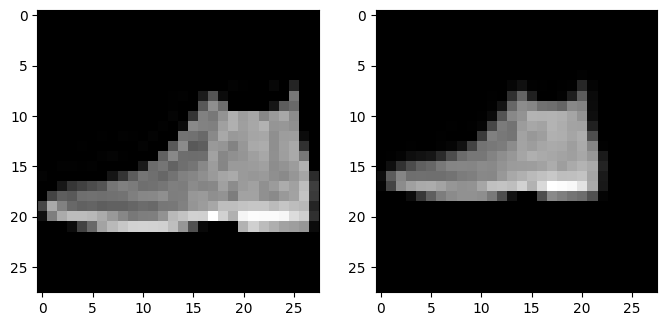

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

for inputs, targets in testing_data:
    
    axs[0].imshow(inputs[0, 0], cmap="gray")

    img = zoom_out(inputs[0])
    axs[1].imshow(img[0], cmap="gray")
    break

## Training with transformations

In [8]:
training_zoom_out = v2.Compose([
    v2.RandomZoomOut(fill=0, side_range=(1., 1.8), p=1),
    v2.Resize((pic_height, pic_width), )
])

In [9]:
dim_hidden = 512
dim_out = 10
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 0.05

training_data = get_dataloader(batch_size=64, train=True, transform=training_zoom_out)
testing_data = get_dataloader(batch_size=64, train=False)
for inputs, targets in training_data:
    _, pic_channels, pic_height, pic_width = inputs.shape
    break

set_seed(12345678)
model = SimpleNetwork(pic_channels * pic_height * pic_width, dim_hidden, dim_out).to(TORCH_DEVICE)
optim = Optim(model, loss_fn, training_data, testing_data)
optim.log_epochs = 1
record = optim.run(num_epochs=10, learning_rate=learning_rate, name="Test")

2025-01-20 16:05:18,573 - INFO: Epoch 1: accuracy 66.2%, loss 0.849006 (time 5.1s)
2025-01-20 16:05:24,280 - INFO: Epoch 2: accuracy 72.9%, loss 0.709323 (time 5.3s)
2025-01-20 16:05:29,767 - INFO: Epoch 3: accuracy 76.2%, loss 0.636296 (time 5.1s)
2025-01-20 16:05:35,217 - INFO: Epoch 4: accuracy 77.6%, loss 0.591320 (time 5.0s)
2025-01-20 16:05:40,955 - INFO: Epoch 5: accuracy 79.2%, loss 0.554916 (time 5.3s)
2025-01-20 16:05:46,460 - INFO: Epoch 6: accuracy 79.1%, loss 0.566624 (time 5.1s)
2025-01-20 16:05:51,918 - INFO: Epoch 7: accuracy 80.7%, loss 0.530551 (time 5.0s)
2025-01-20 16:05:57,414 - INFO: Epoch 8: accuracy 81.7%, loss 0.512308 (time 5.1s)
2025-01-20 16:06:02,855 - INFO: Epoch 9: accuracy 82.2%, loss 0.500578 (time 5.0s)
2025-01-20 16:06:08,386 - INFO: Epoch 10: accuracy 82.3%, loss 0.492520 (time 5.1s)
2025-01-20 16:06:08,387 - INFO: Finished 10 epochs for Test in 55.4s


In [10]:
altered_testing_data = get_dataloader(batch_size=64, train=False, transform=zoom_out)
altered = optim.test(altered_testing_data)
regular = optim.test()

print(f"Altering testing data changes accuracy {regular[0]} -> {altered[0]}")
print(f"Altering testing data changes loss {regular[1]} -> {altered[1]}")

Altering testing data changes accuracy 0.8226 -> 0.7582
Altering testing data changes loss 0.4925200268151654 -> 0.6298230478338375
